In [1]:
import os
import psycopg2
from dotenv import load_dotenv
import pandas as pd
from src.data.db import connect_to_db
from bs4 import BeautifulSoup
import re
from collections import Counter
import numpy as np
from tqdm import tqdm
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()

2025-04-18 14:22:26.159 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/harshavardhan-patil/Work/Projects/canaria/canaria_ml_thp


True

In [2]:
conn = connect_to_db()
# Query to get all jobs data
query = "SELECT * FROM jobs"
df = pd.read_sql(query, conn)
conn.close()

/tmp/ipykernel_621250/1231581779.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [21]:
df.head()

,lid,jobtitle,companyname,jobdescraw,finalzipcode,finalstate,finalcity,companybranchname,jobdescurl,nlpbenefits,nlpskills,nlpsoftskills,nlpdegreelevel,nlpemployment,nlpseniority,correctdate,scrapedlocation
0,07213bcc5db0efec311b1884459defed,"Nuclear Medicine Tech, Full Time, Day Shift",Adventist Health,"<div class=""normalText""><p>Job Description</p>...",93465,"CA,",Templeton,"Adventist Health || Templeton, CA, 93465",https://www.postjobfree.com/job/vubjwa/nuclear...,[],"[Nuclear Medicine, Wound Care, Digestive Disor...",[Computer Literacy],[Associates],Full-time,Entry level,2025-01-06 00:00:00,"Templeton, CA, 93465"
1,53994c1a47063a39ed3bf5509c0d6676,Radiation Therapist - SIGN-ON BONUS,SkinCure Oncology,"<div class=""normalText""><p>Seeking Radiation T...",47802,"IN,",Terre Haute,"SkinCure Oncology || Terre Haute, IN, 47802",https://www.postjobfree.com/job/vt9qzu/radiati...,"[Vision Insurance, Life Insurance, Health Insu...","[Radiation Therapy, Hair Loss, Radiation Prote...",[Customer Service],"[Masters, Certificate]",Full-time,Entry level,2025-01-06 00:00:00,"Terre Haute, IN, 47802"
2,22ea5183b183b0ba1999b465cddc0364,Delivery Driver - Earn Extra Cash,DoorDash,"<div class=""-desktop-no-padding-top"" id=""job-d...",46403,IN,Hobart,"DoorDash || Hobart, IN",https://us.jora.com/job/Delivery-Driver-36f004...,[],[],[],[],Full-time,Entry level,2025-01-06 15:08:54,"Hobart, IN"
3,9255fae6f210f0ca9fdda3c32b99fc1e,Paramedic,AMR,"<div class=""-desktop-no-padding-top"" id=""job-d...",11791,NY,Bay Shore,"AMR || Bay Shore, NY",https://us.jora.com/job/Paramedic-30a825beca41...,[],"[Medical Equipment, Ambulances, Agility]",[Management],[High School],Full-time,Entry level,2025-01-06 06:32:50,"Bay Shore, NY"
4,362836240b3a6ad18c342d840f569622,Sales Lead - White House Black Market,Chico's,"<div class=""normalText""><p>Join our fashion-ob...",49315,"MI,",Byron Center,"Chico's || Byron Center, MI, 49315",https://www.postjobfree.com/job/vt7qu7/sales-l...,[],"[Appraisals, Cash Receipts, Product Knowledge,...","[Sales, Problem Solving, Organizational Skills...","[Associates, High School]",Full-time,Mid-Senior level,2025-01-05 00:00:00,"Byron Center, MI, 49315"


### Null Count

In [55]:
print("Null values per column:")
print(df.isnull().sum())

Null values per column:
lid                   0
jobtitle              0
companyname           0
jobdescraw            0
finalzipcode          0
finalstate            0
finalcity             0
companybranchname     0
jobdescurl            0
nlpbenefits           0
nlpskills             0
nlpsoftskills         0
nlpdegreelevel        0
nlpemployment         0
nlpseniority          0
correctdate          14
scrapedlocation       0
dtype: int64


### Unique values by position

In [56]:
# Count unique values for categorical columns
print("Unique values for categorical columns:")
for col in df.select_dtypes(include=['object']).columns:
    # Skip columns with lists in them
    if df[col].apply(lambda x: isinstance(x, list)).any():
        continue

    if df[col].nunique() < 20:
        print(f"{col}: {df[col].nunique()} unique values")
        print(df[col].value_counts().head(5))

Unique values for categorical columns:
nlpemployment: 7 unique values
nlpemployment
Full-time     69287
Part-time     17445
Contract       8543
Temporary      3396
Internship     1288
Name: count, dtype: int64
nlpseniority: 6 unique values
nlpseniority
Entry level         47660
Mid-Senior level    45116
Associate            2137
Director             2119
Internship           1754
Name: count, dtype: int64


### Check for potential duplicate job postings (same title and company and location)
Pure grouping with title, company and location could be a cheap way to cut down on the amount of jobs we will have to run similarity search on to check duplicates

In [17]:
title_company_dupes = df.duplicated(subset=['jobtitle', 'companyname', 'finalstate', 'finalcity'], keep=False)
duplicate_groups = df[title_company_dupes].groupby(['jobtitle', 'companyname', 'finalstate', 'finalcity']).count()

duplicate_groups.iloc[:, :1]

,,,,lid
jobtitle,companyname,finalstate,finalcity,
(Mechanical) Engineer I/Engineer II/Sr Engineer/Sr Engineer II,BHE GT&S,WV,Bridgeport,2
(USA) Tire & Battery Technician - Automotive,Sam's Club,SD,Sioux Falls,2
13-Week Travel Mammography Technologist,Simonmed Imgaging,NV,Reno,2
1628 La kland St.,H R Cleaning Services LLC,TX,Arlington,2
1st Shift Inventory Control Team Lead,WebstaurantStore,MD,Baltimore,2
...,...,...,...,...
staff - Charge Nurse (RN) - Med Surg,North Mississippi Health Services,MS,Verona,4
staff - Registered Nurse (RN) - ED - Emergency Department - per,North Mississippi Health Services,MS,Verona,2
staff - Registered Nurse (RN) - ICU - Intensive Care Unit - per,Montefiore Medical Center,"NJ,",Edgewater,2


### Checking out some cleaned job descriptions
Why do we have HTML instead of parsed job description in DB?

In [54]:
sample_descs = df['jobdescraw'].iloc[:5]
for sample_desc in sample_descs:
    soup = BeautifulSoup(sample_desc, 'html.parser')
    clean_text = soup.get_text()
    print("\n---Sample clean job description (first 300 chars)---")
    print(clean_text[:1000] + "...")


---Sample clean job description (first 300 chars)---
Job Description

LOCATION SUMMARY:
Located in Templeton amongst the oak trees, Adventist Health Twin Cities has been serving northern San Luis Obispo County since 1977. Comprised of a 122-bed acute care facility, our team provides exceptional care in emergency medicine, orthopedics, obstetrics, digestive disorders, wound care, and various medical, surgical and outpatient services. Locals enjoy weekly farmers markets in downtown Templeton, farm-to-fork dining, beautiful landscapes for hiking and biking, and beach days just fifteen minutes away at Cambria and Morro Bay.

POSITION SUMMARY:
This role is represented by the SEIU. Responsible for the Nuclear Imaging of the newborn, pediatric, adolescent, adult and geriatric patient as ordered by the physician post administration of a radioactive material. Positions and instructs the patient for Nuclear Medicine examinations, adjusts the imaging equipment, determines proper dosage and desir

### Zip code as a sole location identifier
Zip codes could be an excellent way to cut down on the amount of duplicates to check. I am assuming here that same job role in different locations is considered different.


In [4]:
df['finalzipcode'].value_counts()

finalzipcode
NaN       2051
remote     635
80012      108
89119       83
67232       81
          ... 
83012        1
61882        1
30025        1
33883        1
11786        1
Name: count, Length: 17618, dtype: int64

### Analyzing NLP extracted fields

In [ ]:
from src.utils.helpers import parse_array_field

nlp_array_fields = ['nlpbenefits', 'nlpskills', 'nlpsoftskills', 'nlpdegreelevel']

for field in nlp_array_fields:
    if df[field].dtype == 'object':
        # Try to parse as JSON if it's stored as a string
        df[field] = df[field].apply(parse_array_field)

        # Count items and analyze
        item_counts = Counter()
        non_empty_count = 0
        
        for arr in df[field].dropna():
            if arr and len(arr) > 0:
                non_empty_count += 1
                for item in arr:
                    item_counts[item] += 1
        
        print(f"\n{field} analysis:")
        print(f"Postings with {field} data: {non_empty_count} ({non_empty_count/len(df):.2%})")
        
        if item_counts:
            print(f"Top 10 most common {field}:")
            for item, count in item_counts.most_common(10):
                print(f"  {item}: {count}")

# Analyze categorical NLP fields
cat_fields = ['nlpEmployment', 'nlpSeniority']
for field in cat_fields:
    if field in df.columns:
        print(f"\n{field} distribution:")
        print(df[field].value_counts())


nlpbenefits analysis:
Postings with nlpbenefits data: 61230 (61.23%)
Top 10 most common nlpbenefits:
  401K: 40091
  Paid Time Off: 19188
  Life Insurance: 16909
  Vision Insurance: 10145
  Health Insurance: 9507
  Education Assistance: 8392
  Remote: 6737
  Eap: 6144
  Flexible Schedule: 5786
  Dental Insurance: 5342

nlpskills analysis:
Postings with nlpskills data: 90577 (90.58%)
Top 10 most common nlpskills:
  Nursing: 16053
  Travel Nursing: 8870
  Marketing: 6939
  Microsoft Office: 4831
  Licensing: 4436
  Behavioral Health: 4408
  Acute Care: 3580
  Food Delivery: 3537
  Career Development: 3430
  Rehabilitation: 3340

nlpsoftskills analysis:
Postings with nlpsoftskills data: 75630 (75.63%)
Top 10 most common nlpsoftskills:
  Management: 21763
  Customer Service: 18847
  Leadership: 17042
  Operations: 14810
  Sales: 14651
  Scheduling: 10211
  Supervision: 8739
  Collaboration: 8473
  Planning: 7354
  Teamwork: 6972

nlpdegreelevel analysis:
Postings with nlpdegreelevel data:

### Checking time of job posted

Assuming that's what correctDate field corresponds to, although it could also be the original posting date decided based on some other logic...

In [ ]:
df['correctdate'] = pd.to_datetime(df['correctdate'], errors='coerce')
df['post_date'] = df['correctdate'].dt.date
df['post_year'] = df['correctdate'].dt.year
df['post_month'] = df['correctdate'].dt.month
df['post_day'] = df['correctdate'].dt.day
df['post_dayofweek'] = df['correctdate'].dt.dayofweek

print("\nTemporal distribution:")
print(f"Date range: {df['correctdate'].min()} to {df['correctdate'].max()}")

print("\nPosts by year:")
print(df['post_year'].value_counts().sort_index())

print("\nPosts by month:")
print(df['post_month'].value_counts().sort_index())

print("\nPosts by day of week (0=Monday, 6=Sunday):")
print(df['post_dayofweek'].value_counts().sort_index())


Temporal distribution:
Date range: 2024-09-16 00:00:00 to 2025-02-18 00:00:00

Posts by year:
post_year
2024.0      316
2025.0    99670
Name: count, dtype: int64

Posts by month:
post_month
1.0     99660
2.0        10
9.0         1
10.0        1
11.0        1
12.0      313
Name: count, dtype: int64

Posts by day of week (0=Monday, 6=Sunday):
post_dayofweek
0.0    62731
1.0      293
2.0      553
3.0      665
4.0     2131
5.0     2943
6.0    30670
Name: count, dtype: int64


#### Analyzing title, company and location based similarity
Using simple rapidfuzz here.

In [ ]:
from rapidfuzz import fuzz

sampled_df = df.sample(5000).reset_index(drop=True)

# Combine fields into a single string per row
combined = (
    sampled_df['jobtitle'].fillna('') + ' ' +
    sampled_df['companyname'].fillna('') + ' ' +
    sampled_df['finalstate'].fillna('') + ' ' +
    sampled_df['finalcity'].fillna('')
)

# Build similarity matrix
n = len(combined)
similarity_matrix = np.zeros((n, n))

for i in tqdm(range(n)):
    for j in range(i + 1, n):
        score = fuzz.token_sort_ratio(combined[i], combined[j])
        similarity_matrix[i, j] = score
        similarity_matrix[j, i] = score

100%|██████████| 5000/5000 [01:06<00:00, 75.21it/s] 



Potential duplicates with threshold 60: 35110
Sample of potential duplicates:
Similarity Score: 60.3
Record 1: Registered Dental Hygienist | The Job Network | Chula Vista, CA
Record 2: CNA 1 - Clinical Decision Unit | The Job Network | Portland, OR
--------------------------------------------------
Similarity Score: 61.1
Record 1: $$$ Delivery Driver - Patricia Ct --- Daily Cash Take | Domino's | Caseyville, IL,
Record 2: Delivery Driver - Earn Extra Cash | DoorDash | Bay City, MI
--------------------------------------------------
Similarity Score: 69.0
Record 1: Physical Therapist | MVPT Physical Therapy | Queensbury, NY
Record 2: Physical Therapist | Bay State Physical Therapy | Bellingham, MA
--------------------------------------------------
Similarity Score: 62.9
Record 1: Physical Therapist | MVPT Physical Therapy | Queensbury, NY
Record 2: Physical Therapist - Annapolis, MD | Pivot Physical Therapy | Annapolis, MD
--------------------------------------------------
Similarity Sc

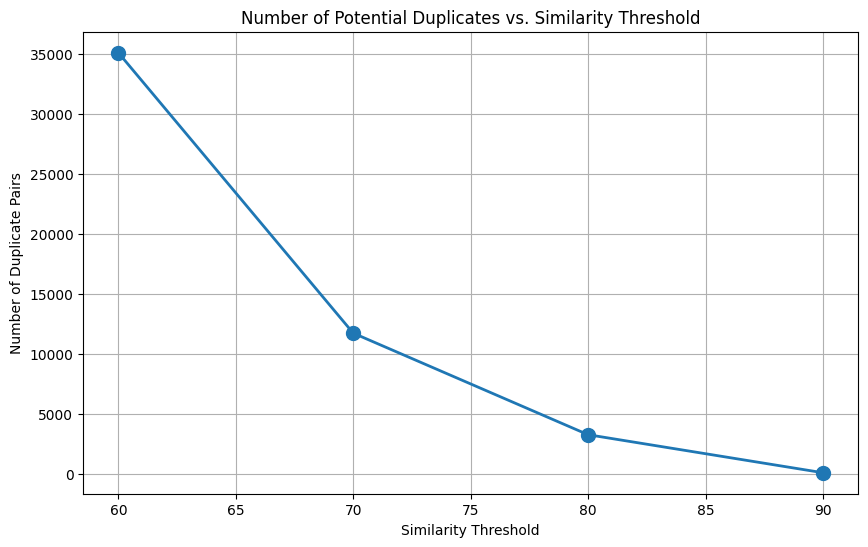

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Function to find potential duplicates using similarity matrix
def find_potential_duplicates(sim_matrix, threshold=70):
    potential_duplicates = []
    sim_scores = []

    for i in range(len(sim_matrix)):
        for j in range(i + 1, len(sim_matrix)):
            if sim_matrix[i, j] >= threshold:
                potential_duplicates.append((i, j))
                sim_scores.append(sim_matrix[i, j])

    return potential_duplicates, sim_scores

# Analyze thresholds
thresholds = [60, 70, 80, 90]
duplicate_counts = []

for threshold in thresholds:
    duplicates, scores = find_potential_duplicates(similarity_matrix, threshold)
    duplicate_counts.append(len(duplicates))

    print(f"\nPotential duplicates with threshold {threshold}: {len(duplicates)}")
    if duplicates:
        print("Sample of potential duplicates:")
        for i, ((idx1, idx2), score) in enumerate(zip(duplicates, scores)):
            if i >= 5:
                break
            print(f"Similarity Score: {score:.1f}")
            print(f"Record 1: {sampled_df['jobtitle'][idx1]} | {sampled_df['companyname'][idx1]} | {sampled_df['finalcity'][idx1]}, {sampled_df['finalstate'][idx1]}")
            print(f"Record 2: {sampled_df['jobtitle'][idx2]} | {sampled_df['companyname'][idx2]} | {sampled_df['finalcity'][idx2]}, {sampled_df['finalstate'][idx2]}")
            print("-" * 50)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, duplicate_counts, marker='o', linewidth=2, markersize=10)
plt.title('Number of Potential Duplicates vs. Similarity Threshold')
plt.xlabel('Similarity Threshold')
plt.ylabel('Number of Duplicate Pairs')
plt.grid(True)
plt.show()

Kind of expected, right tail has the duplicates

100%|██████████| 5000/5000 [00:02<00:00, 1703.29it/s]
/tmp/ipykernel_388235/1267872902.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


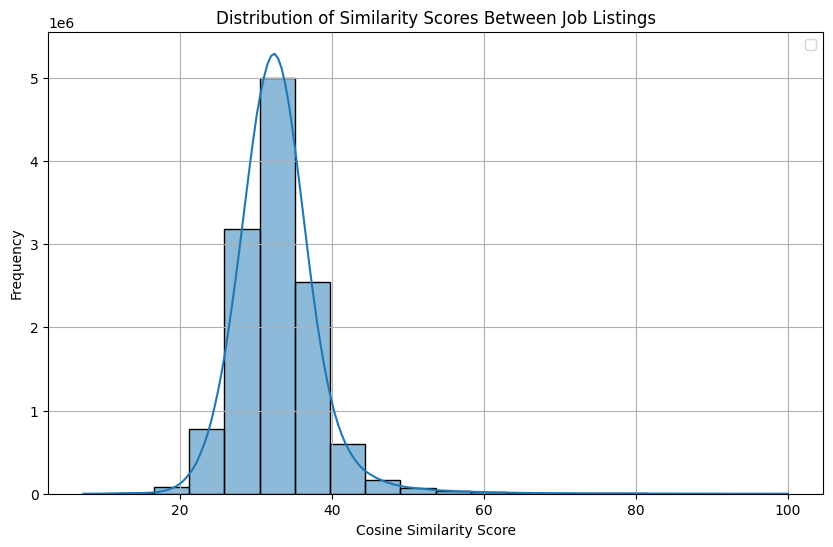

In [ ]:
all_pairs = []
for i in tqdm(range(len(similarity_matrix))):
    for j in range(i+1, len(similarity_matrix)):
        all_pairs.append(similarity_matrix[i, j])

plt.figure(figsize=(10, 6))
sns.histplot(all_pairs, bins=20, kde=True)
plt.title('Distribution of Similarity Scores Between Job Listings')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Analyzing fuzzy similarity of job descriptions

In [ ]:
from src.utils.helpers import preprocess_text
from tqdm import tqdm
from rapidfuzz import fuzz

sampled_df = df.sample(1000, random_state=42).reset_index(drop=True)

processed_descriptions = []
for desc in tqdm(sampled_df['jobdescraw']):
    processed_descriptions.append(preprocess_text(desc))

# Store processed descriptions in sampled dataframe for later reference
sampled_df['processed_desc'] = processed_descriptions

# Build similarity matrix
n = len(processed_descriptions)
similarity_matrix = np.zeros((n, n))

for i in tqdm(range(n)):
    for j in range(i + 1, n):
        # Use token sort ratio for comparing descriptions
        score = fuzz.token_sort_ratio(processed_descriptions[i], processed_descriptions[j])
        similarity_matrix[i, j] = score
        similarity_matrix[j, i] = score



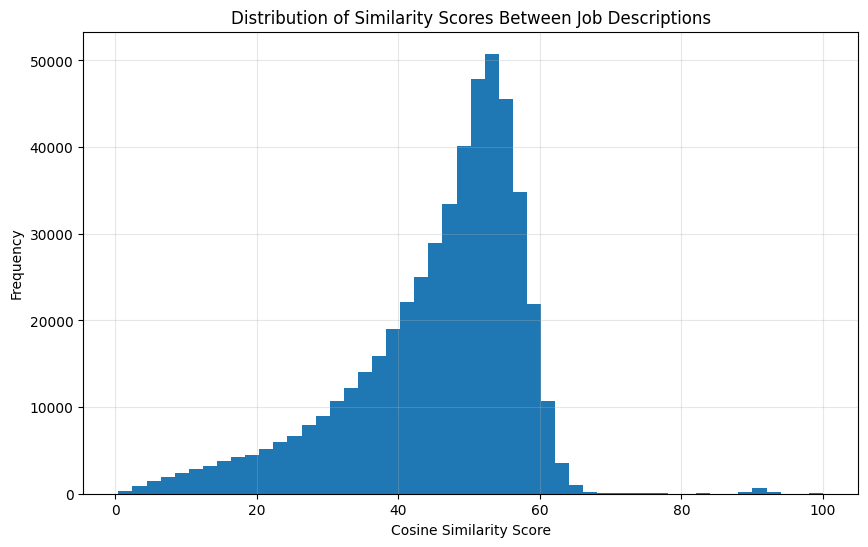


Potential duplicates with threshold 60: 18507
Sample of potential duplicates:
Similarity Score: 82.2
Record 1: Delivery Driver | DoorDash | Waterford, MI
Record 2: Delivery Driver - No Experience Needed | RemoteWorker US | Wheaton, IL
Title Similarity: 56.6%, Company Similarity: 26.1%
--------------------------------------------------
Similarity Score: 89.6
Record 1: Delivery Driver | DoorDash | Waterford, MI
Record 2: Delivery Driver - Sign Up and Start Earning | DoorDash | Shreveport, LA
Title Similarity: 51.7%, Company Similarity: 100.0%
--------------------------------------------------
Similarity Score: 90.9
Record 1: Delivery Driver | DoorDash | Waterford, MI
Record 2: Delivery Driver - Earn Extra Cash | DoorDash | Union, NH
Title Similarity: 62.5%, Company Similarity: 100.0%
--------------------------------------------------
Similarity Score: 91.7
Record 1: Delivery Driver | DoorDash | Waterford, MI
Record 2: Delivery Driver - Sign Up and Start Earning | DoorDash | Duluth, MN
T

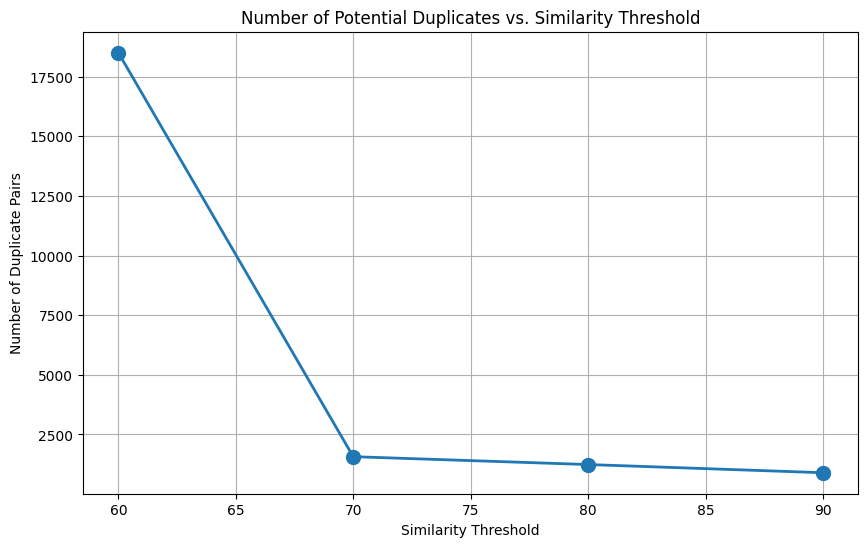

In [12]:
def find_potential_duplicates(sim_matrix, threshold=70):
    potential_duplicates = []
    sim_scores = []

    for i in range(len(sim_matrix)):
        for j in range(i + 1, len(sim_matrix)):
            if sim_matrix[i, j] >= threshold:
                potential_duplicates.append((i, j))
                sim_scores.append(sim_matrix[i, j])

    return potential_duplicates, sim_scores

thresholds = [60, 70, 80, 90]

# Calculate distribution of similarity scores for analysis
sim_scores = []
for i in range(n):
    for j in range(i + 1, n):
        sim_scores.append(similarity_matrix[i, j])

# Plot distribution of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(sim_scores, bins=50)
plt.title('Distribution of Similarity Scores Between Job Descriptions')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig('similarity_distribution.png')
plt.show()

# Analyze thresholds
duplicate_counts = []

for threshold in thresholds:
    duplicates, scores = find_potential_duplicates(similarity_matrix, threshold)
    duplicate_counts.append(len(duplicates))

    print(f"\nPotential duplicates with threshold {threshold}: {len(duplicates)}")
    if duplicates:
        print("Sample of potential duplicates:")
        for i, ((idx1, idx2), score) in enumerate(zip(duplicates, scores)):
            if i >= 5:
                break
            print(f"Similarity Score: {score:.1f}")
            print(f"Record 1: {sampled_df['jobtitle'][idx1]} | {sampled_df['companyname'][idx1]} | {sampled_df['finalcity'][idx1]}, {sampled_df['finalstate'][idx1]}")
            print(f"Record 2: {sampled_df['jobtitle'][idx2]} | {sampled_df['companyname'][idx2]} | {sampled_df['finalcity'][idx2]}, {sampled_df['finalstate'][idx2]}")
            
            # Calculate additional similarity metrics for comparison
            title_sim = fuzz.token_sort_ratio(
                sampled_df['jobtitle'][idx1], 
                sampled_df['jobtitle'][idx2]
            )
            company_sim = fuzz.token_sort_ratio(
                sampled_df['companyname'][idx1], 
                sampled_df['companyname'][idx2]
            )
            
            print(f"Title Similarity: {title_sim:.1f}%, Company Similarity: {company_sim:.1f}%")
            print("-" * 50)

# Plot threshold analysis
plt.figure(figsize=(10, 6))
plt.plot(thresholds, duplicate_counts, marker='o', linewidth=2, markersize=10)
plt.title('Number of Potential Duplicates vs. Similarity Threshold')
plt.xlabel('Similarity Threshold')
plt.ylabel('Number of Duplicate Pairs')
plt.grid(True)
plt.savefig('threshold_analysis.png')
plt.show()

## Key Insights from the Data


### Duplicate Detection Analysis on Title, Company and Location

1. **Threshold Impact**:
   - At 60% similarity: 35,110 potential duplicates (probably too permissive)
   - At 70% similarity: 11,747 potential duplicates
   - At 80% similarity: 3,286 potential duplicates
   - At 90% similarity: 118 potential duplicates (likely true duplicates)

2. **Distribution of Similarity Scores**:
   - The histogram shows most job pairs have similarity scores between 20-50
   - Very few pairs have similarity scores above 60
   - The distribution peaks around 35-40, suggesting this is the typical similarity between random job postings

3. **Examples of Potential Duplicates**:
   - At 60% threshold: Many pairs appear to be different jobs (e.g., "Registered Dental Hygienist" vs "CNA 1")
   - At 70-80% threshold: Many pairs are the same job title but different locations (e.g., Physical Therapist positions in different cities)
   - At 90-100% threshold: Clear duplicates appear, including identical listings (similarity score of 100)


### Threshold Analysis on Job Descriptions

The threshold graph (Image 2) shows:

- A dramatic drop in potential duplicates between thresholds 60 and 70 (from 18,507 to 1,570 pairs)
- A more gradual decline between 70-90 (from 1,570 to 897 pairs)
- This "elbow point" around 70 suggests this could be an optimal threshold value

### Examples of Detected Duplicates

The sample duplicates reveal interesting patterns:

1. **Template Usage by Companies**:
   - DoorDash appears frequently in the samples with very high description similarity (89-92%) despite different locations
   - Some job titles differ slightly (e.g., "Delivery Driver" vs. "Delivery Driver - Earn Extra Cash") but descriptions remain nearly identical

2. **Title vs. Description Similarity**:
   - Some job pairs have high description similarity (82.2%) despite moderate title similarity (56.6%)
   - Several examples show perfect title/company similarity (100%) with slightly different descriptions (~90%)

3. **Cross-Company Similarities**:
   - One example shows high description similarity (82.2%) between jobs from different companies (DoorDash vs. RemoteWorker US)

### Insights

1. **Optimal Threshold Selection**:
   - A threshold around 70-75 appears optimal, capturing genuine duplicates while filtering out coincidental similarities
   - The sharp drop between 60-70 suggests 60 is too permissive, capturing many false positives

2. **Company-Specific Patterns**:
   - DoorDash seems to use highly templated job descriptions across locations
   - This suggests building company-specific similarity models might be valuable. Not sure if time will permit this.

3. **Title vs. Description Complementarity**:
   - Job description similarity captures relationships that title+company similarity might miss
   - A combined approach leveraging both metrics would likely provide the most robust duplicate detection

### Implementation Conclusions
   - Two-stage filtering process: first filter by title/company similarity, then refine using description similarity - could be too expensive?
   - Considering weighting the similarity score based on company (some companies clearly use more templates)

### Challenges
   - Slight variations in data could point to either exact same job posting or similar job posting at a different location.
   - Need a way to cut down on similarity comparisons - considering using NLP as first filters
